# Final Coverage (Multi Parameter) 

This is a Notebook used to determine if adaptive parameter control have any effect on the final coverage.

It is divided into the main sections:

- Prior Predictive Check
- Model specification
- Data analysis

# Prior Predictive Check

Sampling: [a_bar, a_offset, b_offset, sigma_a, sigma_b, theta]


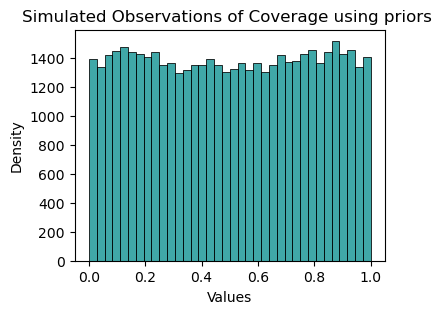

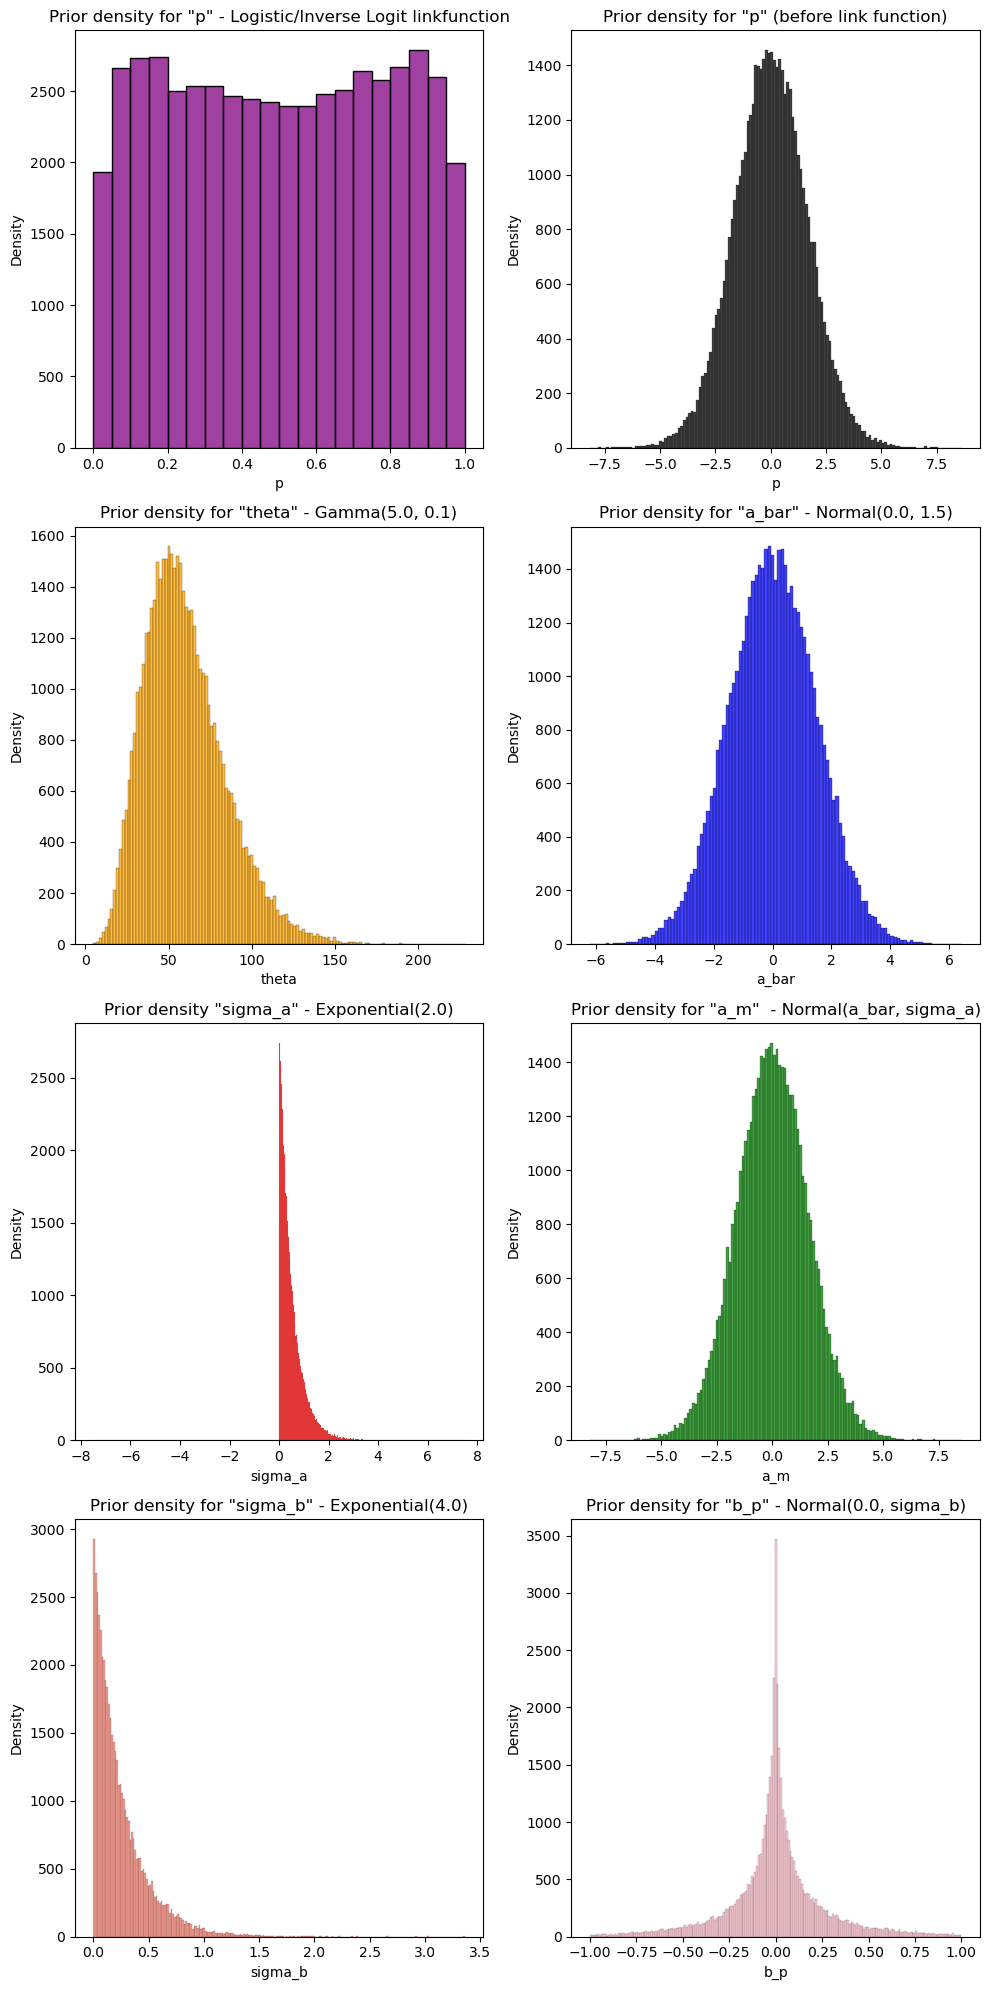

In [5]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def perform_prior_check(s_a, s_b, a_bar_mu, a_bar_sigma):
    with pm.Model():
        # Global Intercept for modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard deviation for Module and Parameter effects
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        
        # Module and Parameter effects with non-centered parameterizations (helps with divergences) 
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)
        

        # Link function (logit), from unbounded to (0,1) probability
        pm.Deterministic('p_before', (a_m + b_p))        
        pm.Deterministic('p', pm.math.sigmoid(a_m + b_p))
        
        # Gamma distriubtion for theta (dispersion/spread) 
        pm.Gamma('theta', alpha=6, beta= 0.1)

        # Sample priors from the model
        idata = pm.sample_prior_predictive(samples=50000)


    # Fetch and flatten priors
    prior_p = idata.prior['p'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()


    # Use alpha and beta as parameters for a Beta distribution to sample observations
    simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)


    # Plot histogram of observations 
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Simulated Observations of Coverage using priors ', 'Values',
                                        'darkcyan', bin_range=(0, 1.0))
    observation_plot.plot()

    # Plot priors for the different parameters
    plots = [
        HistogramPlot(idata.prior['p'].values.flatten(), 'Prior density for "p" - Logistic/Inverse Logit linkfunction', 'p', 'purple', bin_range=(0, 1), bins=20),
        HistogramPlot(idata.prior['p_before'].values.flatten(), 'Prior density for "p" (before link function)', 'p', 'black'),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior density for "theta" - Gamma(5.0, 0.1)', 'theta', 'orange'),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior density for "a_bar" - Normal(0.0, 1.5)', 'a_bar', 'blue'),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior density "sigma_a" - Exponential(2.0)', 'sigma_a', 'red', bin_range=(-7.5, 7.5)),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior density for "a_m"  - Normal(a_bar, sigma_a)', 'a_m', 'green'),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior density for "sigma_b" - Exponential(4.0)', 'sigma_b', 'salmon'),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior density for "b_p" - Normal(0.0, sigma_b)', 'b_p', 'pink', bin_range=(-1, 1)),
    ]

    plot_histograms(plots, 4, 2, figsize=(10,20))


perform_prior_check(2, 4, 0, 1.5)


### UNCOMMENT FOR INTERACTIVE PRIOR CHECK ###

#s_a = FloatSlider(value=2, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
#s_b = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
#a_bar_mu = FloatSlider(value=0, min=-2, max=2, step=0.1, description='alpha bar mu (a_bar_mu):')
#a_bar_sigma = FloatSlider(value=1.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')

#interact(perform_prior_check, s_a=s_a, s_b=s_b, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma)


# Model specification

### Data Preperation

In [3]:
import pymc as pm
import pandas as pd
from utils.design_matrix_creator import get_design_matricies

# Load data
data = pd.read_csv("../multi_parameter/combined_data/statistics.csv")

# Create design matricies that contain dummy variables for each module, parameter and interaction.
observation_matrix, module_matrix, parameter_matrix, _ = get_design_matricies(data, 'Coverage')

Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


In [ ]:
with pm.Model() as model:
    # Global Intercept for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard deviations for Module and Parameter effects
    sigma_a = pm.Exponential('sigma_a', 2.0)
    sigma_b = pm.Exponential('sigma_b', 4.0)
    
    # Module and Parameter effects
    # With non-centered parameterizations (helps with divergences)
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=66)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    
    # Activate the correct module and parameter for each run
    logit_a = pm.math.dot(module_matrix, a_m)
    logit_b = pm.math.dot(parameter_matrix, b_p)

    # Link function (logit), from unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.sigmoid(logit_a + logit_b))
    
    # Beta distribution likelihood with parameters alpha and beta
    theta = pm.Gamma('theta', alpha=6, beta= 0.1) # Dispersion/spread parameter
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=observation_matrix['Coverage'])
    
    # Sample from the model
    trace = pm.sample(5, tune=5, chains=4,return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Model building complete.")

### Save the results

In [ ]:
import arviz as az

az.to_netcdf(trace, "final_coverage_model_multi_parameter.nc")

# Data analysis


### Generate summary object (without transformations)

In [3]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace
import pandas as pd
pd.set_option('display.max_rows', 500)  # Increase number of rows

# Example usage
trace = az.from_netcdf("final_coverage_model_multi_parameter.nc") # REPLACE
variable_list = ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p']
transformations = {}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
summary = az.summary(idata, variable_list, hdi_prob=0.89)

### Replace numeric identifiers with descriptive identifiers

In [4]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../multi_parameter/combined_data/statistics.csv"), 'Coverage')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary, 'a_m', replacement=module_names)
update_table(summary, 'b_p', replacement=parameter_names)
update_table(summary, 'g_mp', replacement=interaction_names)

summary.sort_values(by='mean', ascending=True)

Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


mean     sd  hdi_5.5%  hdi_94.5%  \
a_m[packages]                            -2.880  0.024    -2.918     -2.842   
a_m[cmd]                                 -2.484  0.021    -2.517     -2.450   
a_m[dict_unpacking]                      -1.782  0.016    -1.809     -1.756   
a_m[signals]                             -1.416  0.015    -1.440     -1.392   
a_m[python]                              -1.214  0.014    -1.236     -1.191   
a_m[return_from_generator]               -0.984  0.014    -1.006     -0.962   
a_m[py_base]                             -0.911  0.014    -0.932     -0.889   
a_m[positional_validation]               -0.850  0.013    -0.870     -0.828   
a_m[journaling]                          -0.740  0.013    -0.761     -0.720   
a_m[lazy_import]                         -0.118  0.012    -0.137     -0.098   
b_p[Elite|TestChangeProb]                -0.020  0.016    -0.044      0.003   
b_p[StatemInsertProb|TestDeleteProb]     -0.011  0.013    -0.033      0.008   
b_p[ChromLen|TestDeleteProb]             -0.011  0.013    -0.031      0.009   
b_p[Elite|TourSize]                      -0.010  0.013    -0.031      0.008   
b_p[ChromLen|Crossover]                  -0.009  0.012    -0.029      0.010   
b_p[TestChangeProb|TestDeleteProb]       -0.007  0.012    -0.027      0.012   
b_p[ChangeParamProb|ChromLen]            -0.007  0.012    -0.028      0.011   
b_p[Elite|TestInsertProb]                -0.007  0.012    -0.026      0.012   
b_p[ChangeParamProb|TestDeleteProb]      -0.006  0.012    -0.025      0.013   
b_p[Elite|Pop]                           -0.006  0.012    -0.026      0.012   
b_p[TestChangeProb|TourSize]             -0.005  0.012    -0.024      0.014   
b_p[Crossover|RandPert]                  -0.004  0.011    -0.023      0.014   
b_p[Crossover|Pop]                       -0.004  0.012    -0.023      0.014   
b_p[ChromLen|TourSize]                   -0.004  0.012    -0.024      0.014   
b_p[ChangeParamProb|TestChangeProb]      -0.004  0.012    -0.024      0.014   
b_p[ChromLen|Pop]                        -0.004  0.012    -0.023      0.015   
b_p[Elite|TestDeleteProb]                -0.004  0.012    -0.023      0.015   
b_p[ChromLen|Elite]                      -0.004  0.012    -0.023      0.014   
b_p[Pop|TestChangeProb]                  -0.004  0.012    -0.023      0.014   
b_p[StatemInsertProb|TourSize]           -0.003  0.012    -0.022      0.015   
b_p[ChangeParamProb|Pop]                 -0.003  0.012    -0.022      0.015   
b_p[RandPert|StatemInsertProb]           -0.003  0.012    -0.022      0.015   
b_p[Elite|RandPert]                      -0.003  0.011    -0.021      0.016   
b_p[TestDeleteProb|TourSize]             -0.002  0.012    -0.021      0.017   
b_p[StatemInsertProb|TestInsertProb]     -0.002  0.012    -0.020      0.017   
b_p[TestInsertProb|TourSize]             -0.001  0.011    -0.020      0.017   
b_p[ChromLen|StatemInsertProb]           -0.001  0.012    -0.021      0.016   
b_p[Crossover|TestChangeProb]            -0.001  0.012    -0.020      0.017   
b_p[Pop|TestDeleteProb]                  -0.001  0.011    -0.019      0.018   
b_p[TestDeleteProb|TestInsertProb]       -0.001  0.011    -0.020      0.017   
b_p[ChangeParamProb|RandPert]            -0.001  0.012    -0.020      0.017   
b_p[Crossover|StatemInsertProb]          -0.000  0.012    -0.019      0.018   
b_p[Pop|TourSize]                         0.000  0.012    -0.019      0.018   
b_p[ChromLen|TestInsertProb]              0.000  0.012    -0.019      0.018   
b_p[TestInsertionProb|TourSize]          -0.000  0.012    -0.019      0.018   
b_p[ChangeParamProb|Crossover]           -0.000  0.012    -0.019      0.018   
b_p[ChangeParamProb|TourSize]             0.001  0.012    -0.018      0.019   
b_p[Elite|StatemInsertProb]               0.001  0.011    -0.017      0.019   
b_p[Crossover|TourSize]                   0.001  0.012    -0.017      0.020   
b_p[ChromLen|RandPert]                    0.002  0.012    -0.017      0.020   
b_p[TestChange

### Plot the prior distributions and their assosicated trace plots

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

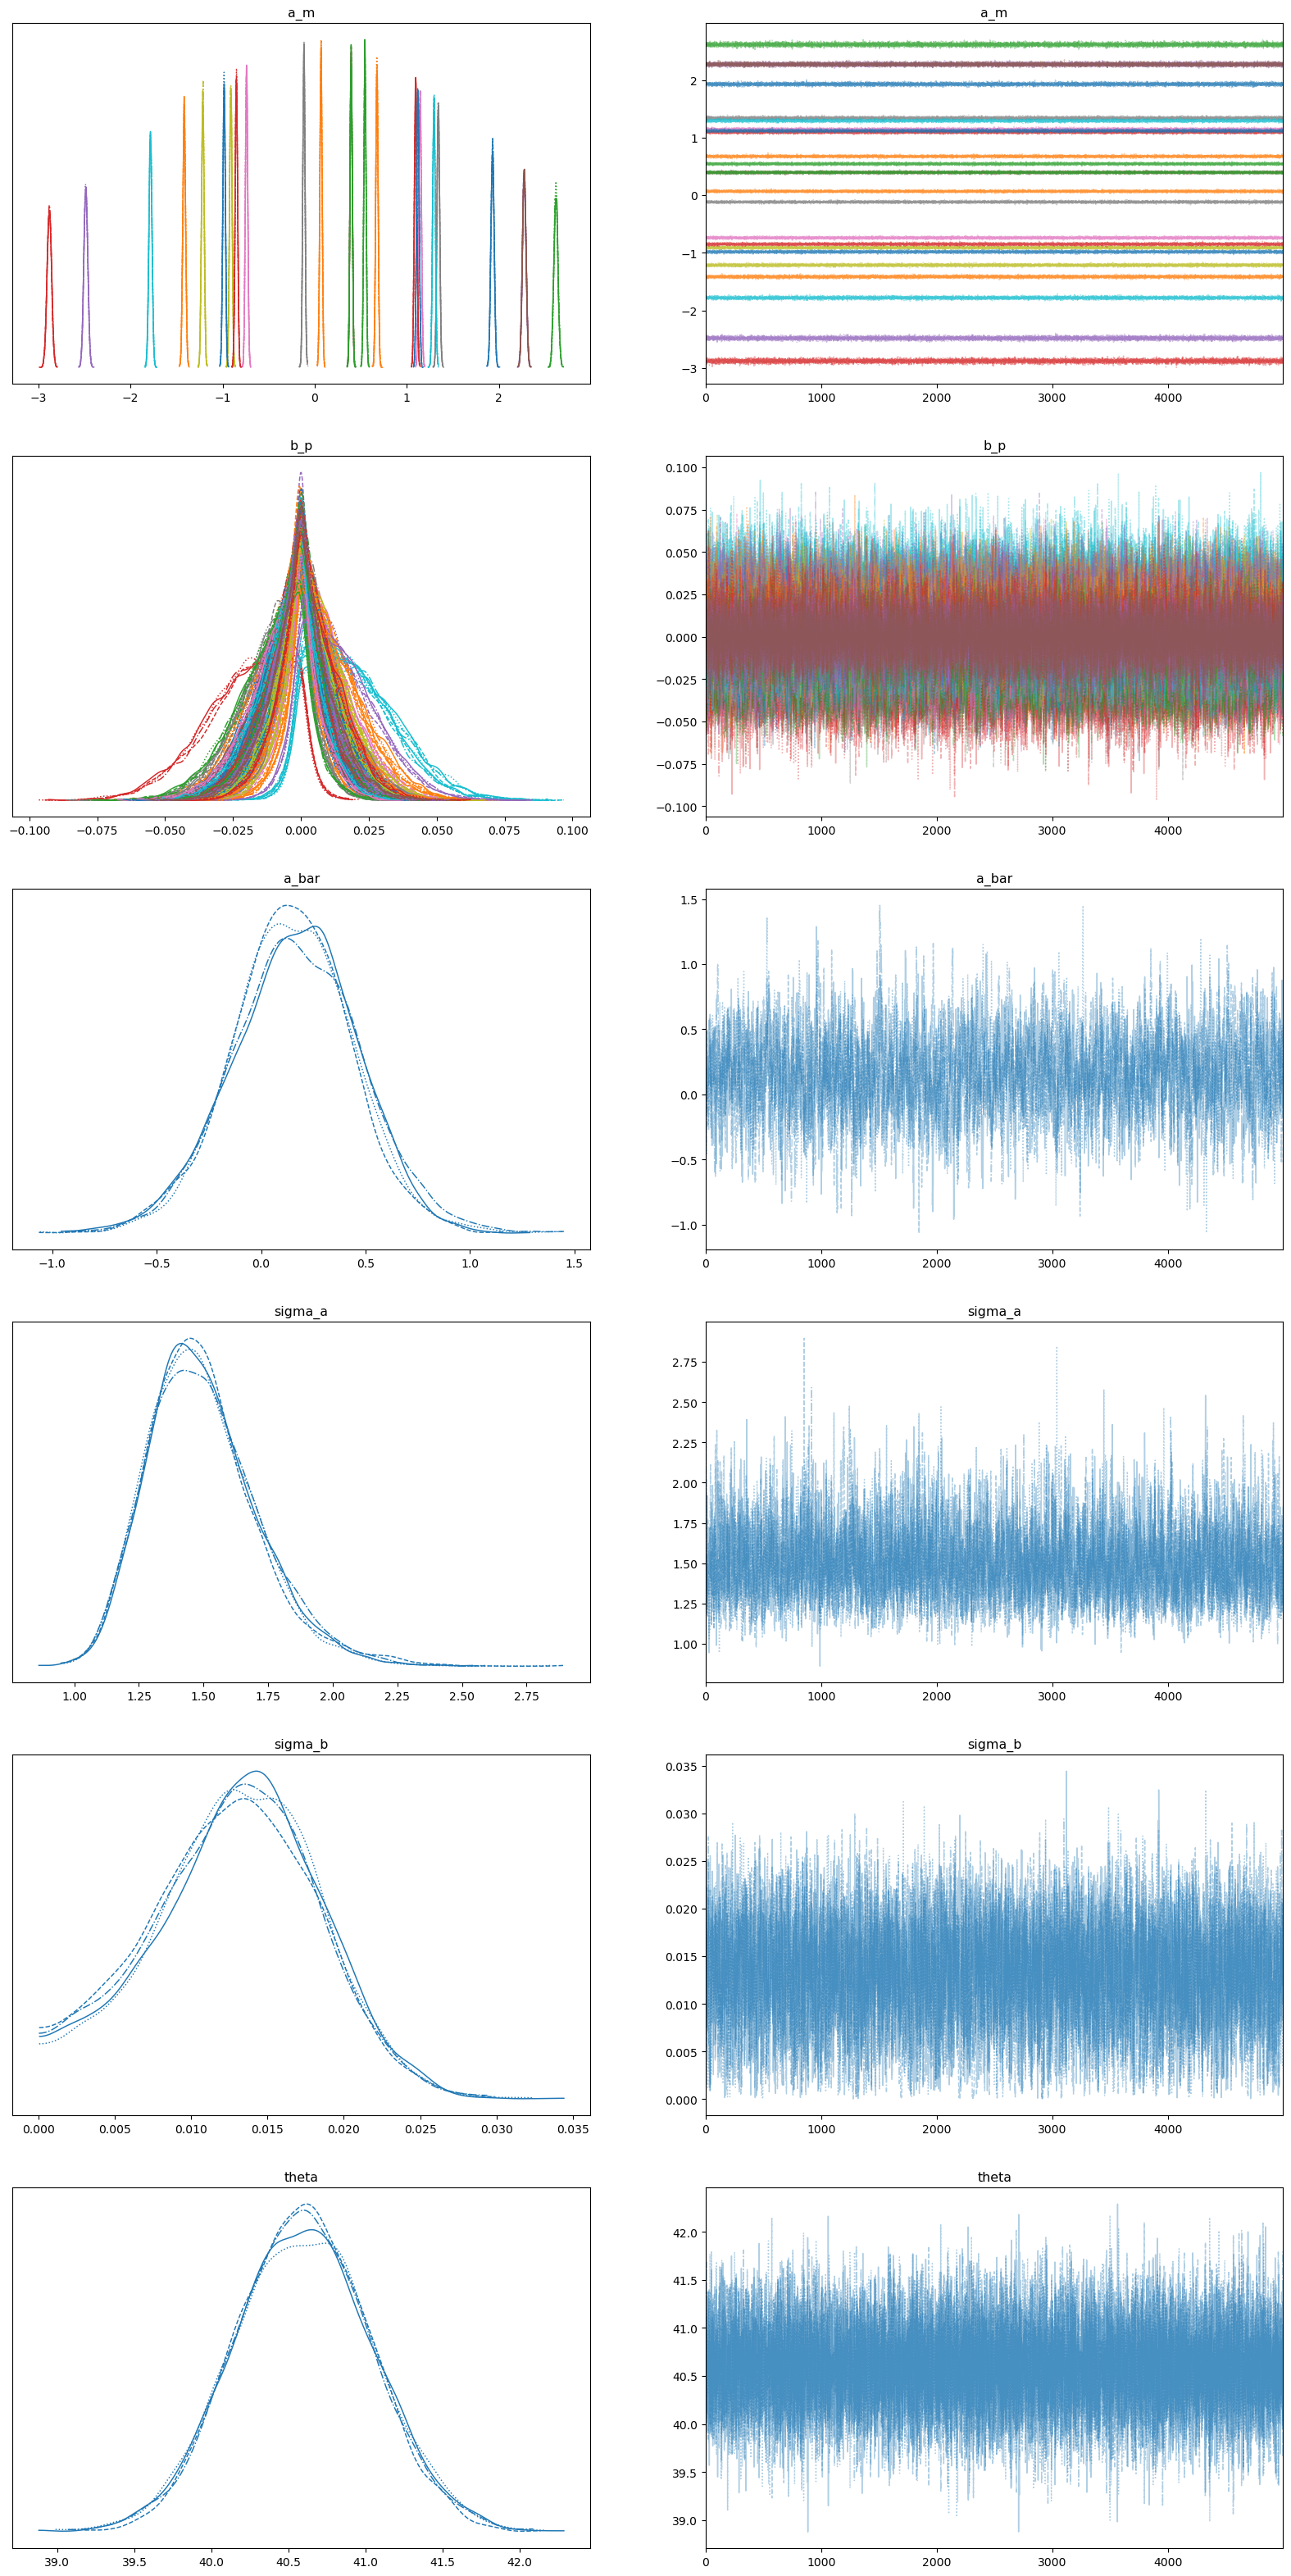

In [6]:
import matplotlib.pyplot as plt

az.plot_trace(idata, var_names=['a_m', 'b_p', 'a_bar', 'sigma_a', 'sigma_b', 'theta'], figsize=(20, 40))
#for ax in axes[:, 1]:  # Assumes trace plots are in the second column
#    ax.set_visible(False)
#plt.show()

### Transformed effects

In [7]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace, logit_to_probability
import pandas as pd
pd.set_option('display.max_rows', 500)  # Increase number of rows

# Example usage
trace = az.from_netcdf("final_coverage_model_multi_parameter.nc") # REPLACE
variable_list = ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p']
transformations = {
    'a_m': logit_to_probability,
    'b_p': logit_to_probability,
    'g_mp':logit_to_probability,
    'a_bar': logit_to_probability
}

idata_transformed = create_inference_data_from_trace(trace, variable_list, transformations)
summary_transformed = az.summary(idata_transformed, variable_list, hdi_prob=0.89)

KeyError: 'sigma_g'

In [ ]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../multi_parameter/combined_data/statistics.csv"), 'AlgorithmIterations')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary_transformed, 'a_m', replacement=module_names)
update_table(summary_transformed, 'b_p', replacement=parameter_names)
update_table(summary_transformed, 'g_mp', replacement=interaction_names)

summary_transformed.sort_values(by='mean', ascending=True)

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


mean     sd  hdi_5.5%  \
sigma_b                                           0.013  0.008     0.000   
sigma_g                                           0.043  0.006     0.033   
a_m[packages]                                     0.052  0.002     0.049   
a_m[cmd]                                          0.076  0.002     0.073   
a_m[dict_unpacking]                               0.140  0.003     0.135   
a_m[signals]                                      0.195  0.004     0.190   
a_m[return_from_generator]                        0.228  0.004     0.221   
a_m[python]                                       0.229  0.004     0.222   
a_m[py_base]                                      0.279  0.004     0.272   
a_m[positional_validation]                        0.287  0.004     0.280   
a_m[journaling]                                   0.324  0.004     0.316   
g_mp[return_from_generator x Pop]                 0.444  0.014     0.421   
a_m[lazy_import]                                  0.470  0.005     0.462   
g_mp[return_from_generator x ChromLen]            0.478  0.010     0.462   
g_mp[return_from_generator x TestDeleteProb]      0.481  0.010     0.465   
g_mp[return_from_generator x StatemInsertProb]    0.485  0.009     0.470   
a_m[yield_from]                                   0.489  0.005     0.482   
g_mp[positional_validation x TestInsertProb]      0.491  0.009     0.477   
g_mp[yield_from x ChangeParamProb]                0.492  0.009     0.478   
g_mp[py_base x RandPert]                          0.493  0.009     0.479   
g_mp[journaling x Crossover]                      0.494  0.009     0.479   
g_mp[journaling x TourSize]                       0.494  0.009     0.481   
g_mp[helpers x ChangeParamProb]                   0.495  0.010     0.479   
g_mp[positional_validation x Crossover]           0.495  0.009     0.481   
g_mp[config x Pop]                                0.495  0.009     0.480   
g_mp[yield_from x TestDeleteProb]                 0.495  0.009     0.482   
g_mp[yield_from x TourSize]                       0.495  0.009     0.481   
g_mp[yield_from x RandPert]                       0.495  0.009     0.481   
g_mp[positional_validation x TourSize]            0.495  0.009     0.480   
g_mp[py_base x StatemInsertProb]                  0.496  0.009     0.481   
g_mp[positional_validation x TestChangeProb]      0.496  0.009     0.482   
g_mp[py_base x Pop]                               0.496  0.009     0.482   
g_mp[yield_from x Pop]                            0.496  0.009     0.482   
g_mp[positional_validation x ChromLen]            0.496  0.009     0.481   
g_mp[positional_validation x TestDeleteProb]      0.496  0.009     0.481   
g_mp[h_base x Elite]                              0.496  0.009     0.482   
g_mp[helpers x TourSize]                          0.496  0.009     0.482   
b_p[Pop]                                          0.496  0.004     0.490   
g_mp[packages x Crossover]                        0.497  0.010     0.482   
g_mp[py_base x ChromLen]                          0.497  0.009     0.484   
g_mp[h_base x Pop]                                0.497  0.009     0.482   
g_mp[helpers x Pop]                               0.497  0.009     0.482   
g_mp[packages x TestChangeProb]                   0.497  0.010     0.482   
g_mp[helpers x TestDeleteProb]                    0.497  0.009     0.481   
g_mp[dict_unpacking x TourSize]                   0.497  0.010     0.481   
g_mp[packages x TestInsertionProb]                0.497  0.010     0.481   
g_mp[h_base x TestDeleteProb]                     0.497  0.009     0.483   
g_mp[h_base x ChromLen]                           0.497  0.009     0.482   
g_mp[packages x Elite]                            0.497  0.010     0.481   
g_mp[dict_unpacking x RandPert]                   0.497  0.010     0.482   
g_mp[packages x ChangeParamProb]                  0.497  0.010     0.482   
g_mp[return_from_generator x TestChangeProb]      0.497  0.009     0.483   
g_mp[config x Elite]   

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'g_mp'}>,
        <Axes: title={'center': 'g_mp'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'sigma_g'}>,
        <Axes: title={'center': 'sigma_g'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

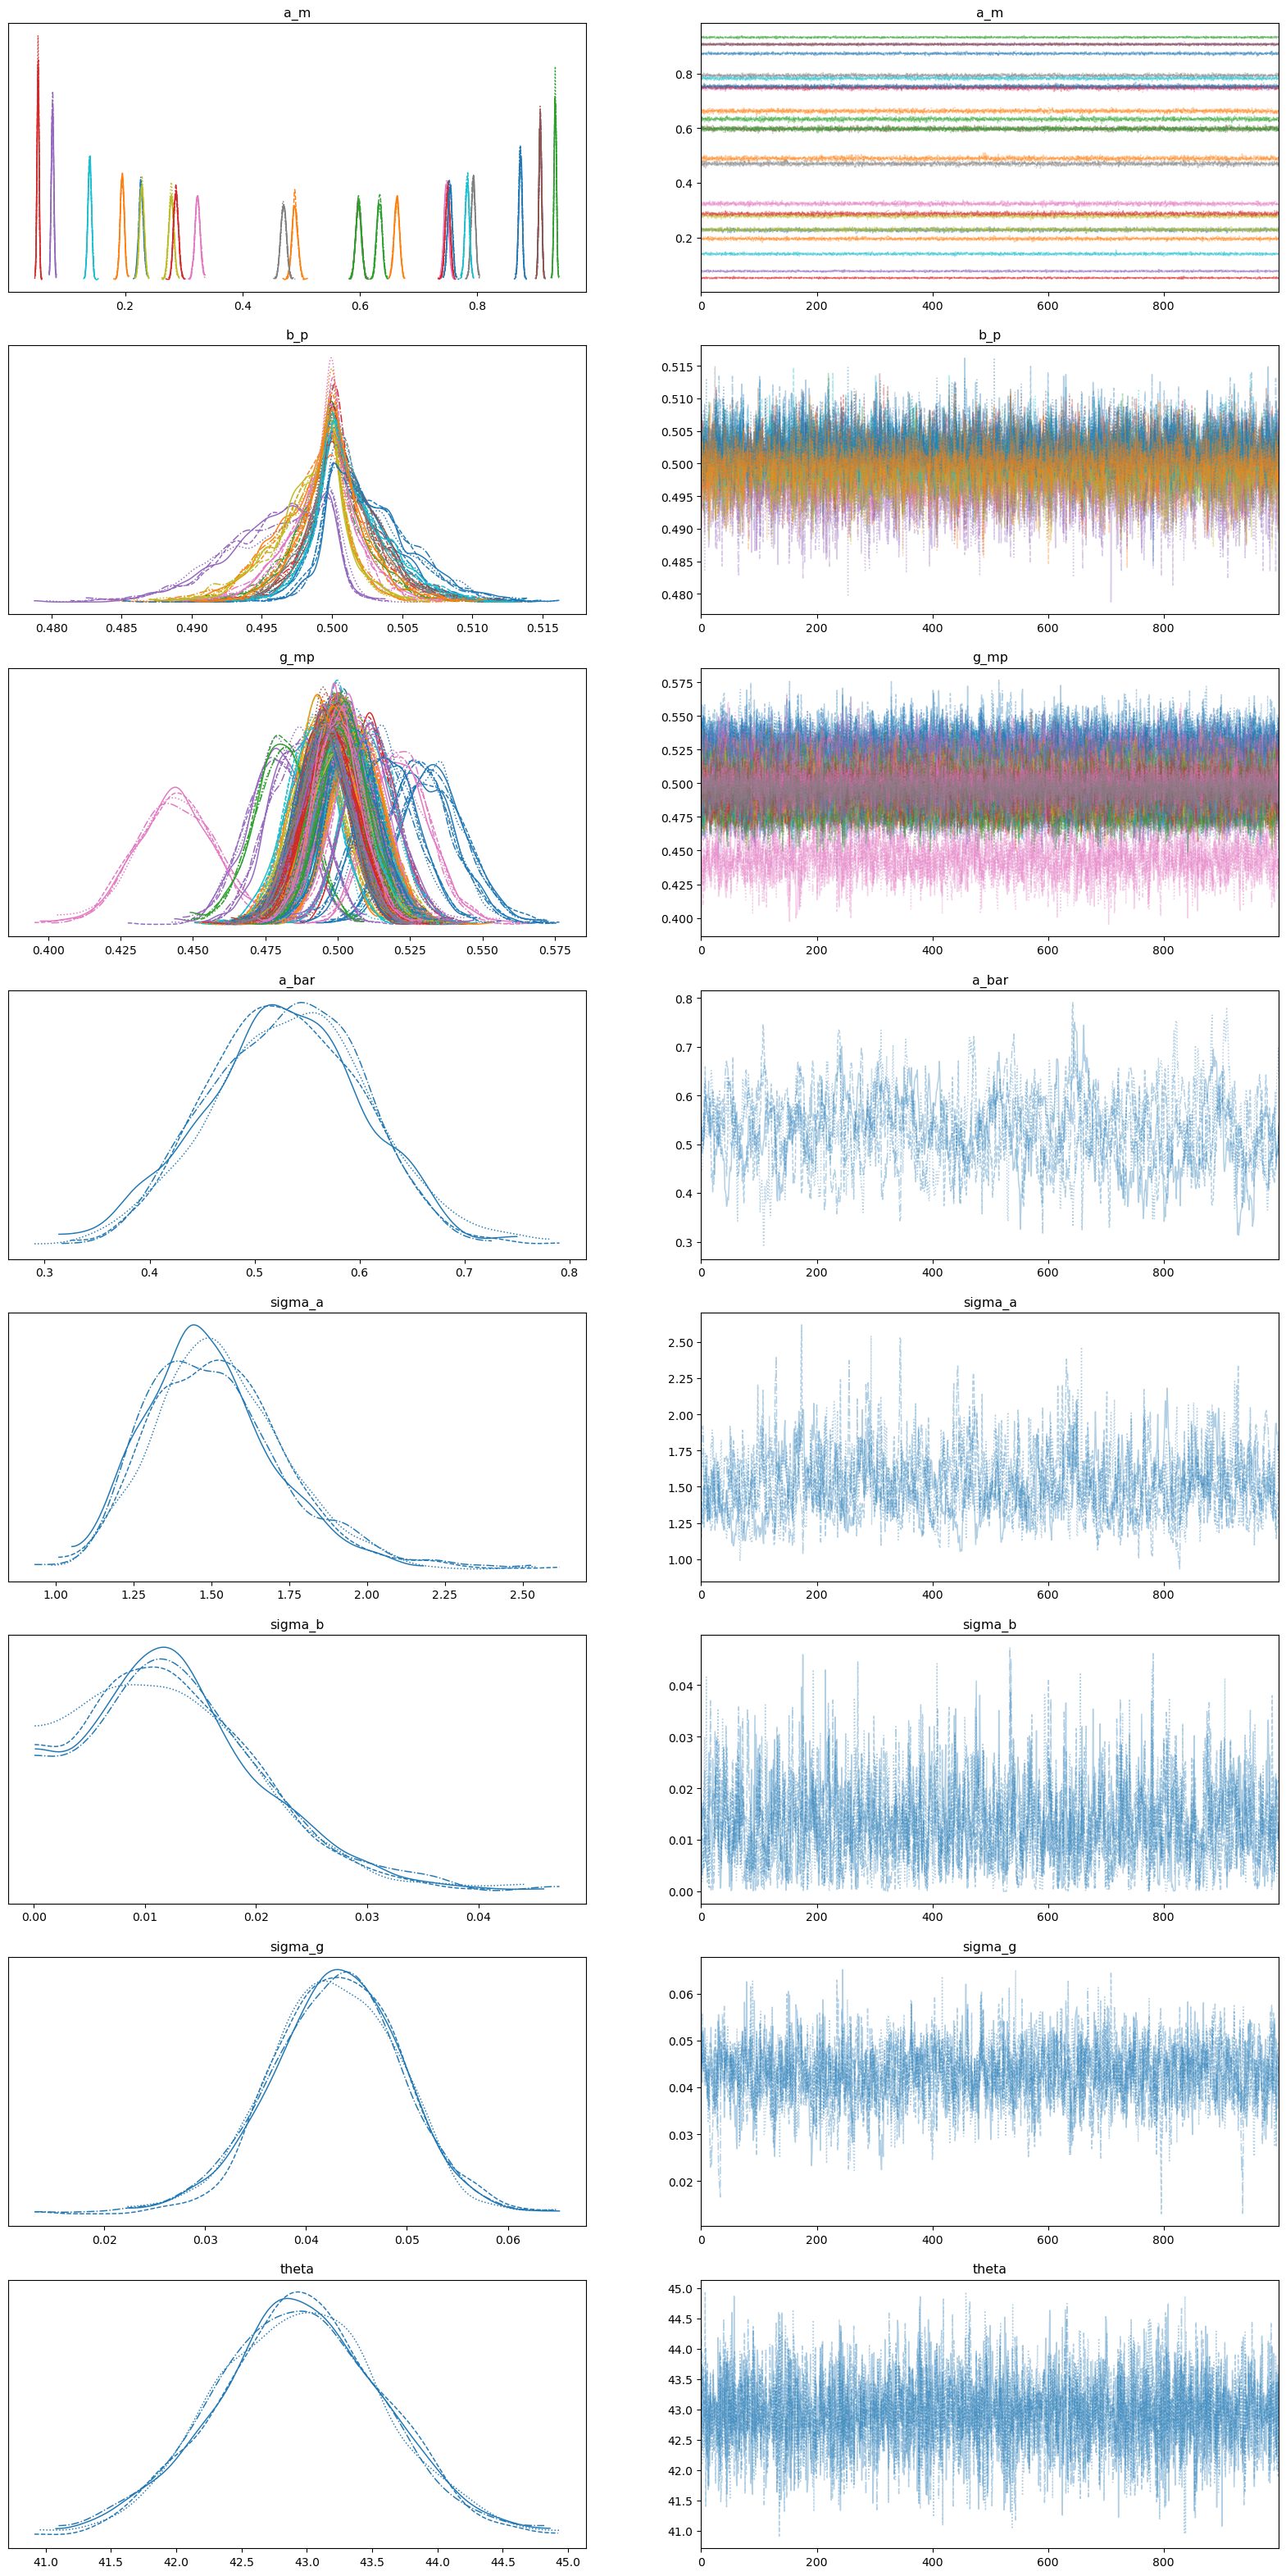

In [ ]:
az.plot_trace(idata_transformed, var_names=['a_m', 'b_p', 'g_mp', 'a_bar', 'sigma_a', 'sigma_b', 'sigma_g', 'theta'], figsize=(20, 40))